In [1]:
using CSV, DataFrames, LinearAlgebra, Dates, Statistics, VegaLite, Plots, CategoricalArrays, StatsPlots, URIParser
using FilePaths, URIParser, Distributions

In [2]:
function pct_change(input, t)
    res = @view(input[t + 1:end]) ./ @view(input[1:end - t]) .- 1
    [repeat([missing], t)..., res]'
end

pct_change (generic function with 1 method)

In [4]:
transactions = "https://drive.google.com/uc?export=download&id=1qY0aUZd98KS0J7JOqWdPoa27DbiwPz1i"
geojson = "https://drive.google.com/uc?export=download&id=1T12uhUyAwBdwZ4EKzAjXb3X1PiY3RBIp"
transactions_filename = "nyc_real_estate_211231.csv"
geojson_filename = "nyc_lotblock.geojson"

#download(transactions, transactions_filename)
#download(geojson, geojson_filename)

"nyc_lotblock.geojson"

In [149]:
df = CSV.read(transactions_filename, 
    DataFrame; select=[:block, :lot, :uid, :sale_price, :sale_date, :borough, :house_class, :neighborhood],
    types=Dict(:uid=>String, :sale_price=>Int64, :sale_date=>Date)) |> 
    df -> sort(df, [:uid, :sale_date]) |>
    df -> df #[df.sale_date .> Date("2018-12-31"), :]
df.sale_date = Dates.lastdayofquarter.(df.sale_date)
dropmissing!(df)

grouped = groupby(df, [:borough, :uid])
df = df[combine(grouped, :sale_price => (x -> median(x) / 4 .< x .< median(x) * 4) => :is_clean).is_clean, :]
grouped = groupby(df, [:borough, :uid])
grouped = grouped[combine(grouped, nrow).nrow .> 1]
df = combine(grouped, names(df)...)

function calc_index(df)
    grouped = groupby(df, [:borough, :uid])

    rng = sort(unique(df.sale_date))

    n = sum(combine(grouped, gp -> nrow(gp) - 1).x1)
    p = size(rng, 1)  # degrees of freedom aka num of periods
    X = zeros(Int64, (n, p))   # first column of X will become Y vector
    Δ = zeros(Int64, (n, 1))
    row = 1

    for group in grouped
        for i in 1:size(group,1)-1
            buy = group[i, :]
            sell = group[i+1, :]
            q₁ = findfirst(rng .== buy.sale_date)
            q₂ = findfirst(rng .== sell.sale_date)
            X[row, q₁] = -buy.sale_price
            X[row, q₂] = sell.sale_price
            Δ[row] = q₂ - q₁ 
            row += 1
        end
    end

    Y = -X[:, 1]
    X = X[:, 2:end]
    Z = sign.(X)
    
    # check for periods with no transactions (leads to singular matrix)
    s = sum(Z, dims=1)
    skip = [i for (i, k) in enumerate(s) if k == 0]
    X = X[:, setdiff(1:end, skip)]
    Z = Z[:, setdiff(1:end, skip)]
    rng = rng[setdiff(1:end, skip)]

    β = inv(Z'X)Z'Y

    e = (Y - X * β)[:]
    h = inv(Δ' * Δ) * Δ' * e.^2
    h = max.(h, 0)

    w = sqrt.(Δ * h)[:]
    ω = 1 ./ w
    Ω = Diagonal(w)

    β = inv(Z' * inv(Ω) * X) * Z' * inv(Ω) * Y
    
    # compute confidence interval
    û = Y - X * β
    V = Z' * û * û' * Z
    Var = inv(Z' * X) * V * inv(X' * Z)
    t = quantile(TDist(p), 0.68)
    se = sqrt.(diag(Var))
    insert!(β, 1, 1)    # index starts at 1
    insert!(se, 1, 0)   # std error of first period is 0
    return DataFrame(index=1 ./ β, 
        ci₀ = 1 ./ (β - t * se), 
        ci₁ = 1 ./ (β + t * se), 
        dates=rng)
end

calc_index (generic function with 1 method)

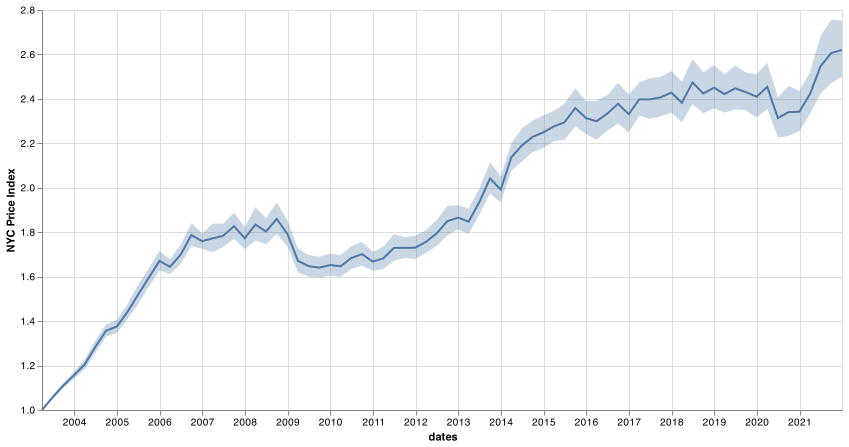

In [150]:
idx = calc_index(df)
plot(idx.dates, idx.index, label="NYC", legend=:topleft, title="Real Estate Price Index", palette=:seaborn_colorblind)
idx

idx |>
@vlplot(x=:dates) +
@vlplot(
    mark=:errorband,
    y={
        :ci₀,
        title="NYC Price Index",
        scale= {zero = false }
    },
    y2={
        :ci₁
    }
) +
@vlplot(
    :line,
    y = :index,
    width=800,
    height=400
)

In [151]:
gdf = groupby(df[((df.house_class .!= "Coop") 
            .& (df.borough .!= "Bronx")
            .& .!((df.house_class .== "SFH") .& (df.borough .== "Manhattan")) 
            .& .!((df.house_class .== "Condo") .& (df.borough .== "Staten Island"))
            ), :], [:borough, :house_class])
idxb = combine(gdf) do sdf
    calc_index(sdf)
end

idxb |> @vlplot(
    facet = {row = {field = :borough},
             column = {field = :house_class},
    },
    spec = {
        layer = [
            {
                mark = :errorband,
                x = :dates,
                y = :ci₀,
                y2 =:ci₁,
                width=300,
                height=150
            },
            {
                mark = :line,
                x = :dates,
                y = {
                    :index,
                    title="NYC Price Index",
                    scale= {zero = false }
                }
            }
        ]
     }
 ) |> save("index.png")

In [152]:
df[(df.house_class .== "SFH") .& (df.borough .== "Manhattan"), :]

,borough,uid,neighborhood,block,lot,sale_price,sale_date
,String15,String,String31,Int64,Int64,Int64,Date
1,Manhattan,1123_114,Upper West Side (59-79),1123,114,15000000,2009-06-30
2,Manhattan,1123_114,Upper West Side (59-79),1123,114,15000000,2017-12-31
3,Manhattan,1123_45,Upper West Side (59-79),1123,45,13715675,2017-12-31
4,Manhattan,1123_45,Upper West Side (59-79),1123,45,9500000,2018-12-31
5,Manhattan,1127_46,Upper West Side (59-79),1127,46,14500000,2007-12-31
6,Manhattan,1127_46,Upper West Side (59-79),1127,46,18850000,2010-09-30
7,Manhattan,1128_49,Upper West Side (59-79),1128,49,13100000,2018-03-31
8,Manhattan,1128_49,Upper West Side (59-79),1128,49,13900000,2021-09-30
9,Manhattan,1128_59,Upper West Side (59-79),1128,59,7500000,2010-03-31


In [9]:
@vlplot(
    :geoshape,
    width=500, height=300,
    data={
        url=URI(geojson),
        format={
            type=:topojson,
            feature=:BORO
        }
    }, 
    mark={
        :geoshape,
        stroke=:black,
        strokeWidth=2
    },
    projection={type=:albersUsa}
) |> save("blocks.pdf")

In [83]:
yy = df[(df.sale_date .== Date("2021-12-31")) .| (df.sale_date .== Date("2020-12-31")), :]
gdf = groupby(yy, [:borough, :uid])
gdf = gdf[combine(gdf, nrow).nrow .> 1]
yy = combine(gdf, names(yy)...)
combine(groupby(yy, [:borough, :block, :uid]), :sale_price => x -> size(x, 1) > 1 ? (x[2] / x[1] - 1) : nothing => :yy_px; renamecols=false)
#gdf[1]

,borough,block,uid,sale_price
,String15,Int64,String,Float64
1,Manhattan,1056,1056_2a,-0.1854
2,Brooklyn,1059,1059_4,0.263441
3,Brooklyn,1063,1063_3,0.0855615
4,Queens,11051,11051_85,0.195431
5,Queens,11227,11227_66,0.924322
6,Staten Island,1123,1123_25,0.761895
7,Queens,11332,11332_17,0.548889
8,Manhattan,1158,1158_7h,-0.375439
9,Manhattan,1197,1197_3f,-0.372727


In [103]:
apt = df[(df.block .== 886) .& (df.lot .== 1202), ["sale_price", "sale_date"]]

,sale_price,sale_date
,Int64,Date
1,1050000,2018-09-30
2,967338,2020-12-31


In [153]:
idx = calc_index(df[(df.borough .== "Manhattan") .& (df.house_class .== "Condo"), :])

,index,ci₀,ci₁,dates
,Float64,Float64,Float64,Date
1,1.0,1.0,1.0,2003-03-31
2,1.08049,1.0889,1.07221,2003-06-30
3,1.09995,1.1047,1.09524,2003-09-30
4,1.14003,1.14852,1.13166,2003-12-31
5,1.22558,1.24348,1.20819,2004-03-31
6,1.31709,1.33703,1.29773,2004-06-30
7,1.38794,1.41651,1.36049,2004-09-30
8,1.3702,1.39423,1.34697,2004-12-31
9,1.48511,1.50946,1.46154,2005-03-31


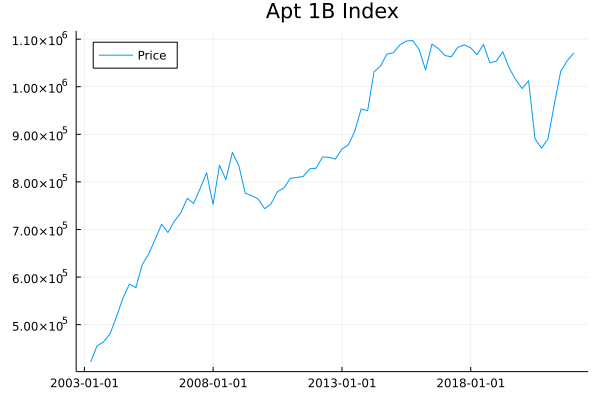

In [111]:
idxₐ = outerjoin(apt, idx, on = :sale_date => :dates)
f = idxₐ.sale_price[1] / idxₐ.index[1]
transform!(idxₐ, :index => x -> x * f; renamecols=false)
sort!(idxₐ, :sale_date)
plot(idxₐ.sale_date, idxₐ.index, label="Price", legend=:topleft, title="Apt 1B Index")

In [113]:
last(idxₐ, 5)

,sale_price,sale_date,index
,Int64?,Date,Float64
1,967338,2020-12-31,8.9032e5
2,missing,2021-03-31,9.62886e5
3,missing,2021-06-30,1.0324e6
4,missing,2021-09-30,1.05463e6
5,missing,2021-12-31,1.07076e6
